# Python spatial notebooks 2 : données vectorielles avec geopandas

Cyril Bernard, déc 2021

## Objectifs

Le but de cette présentation est d'explorer les possibilités de Python 
en matière de données spatiales, et plus particulièrement les **données vectorielles**.

Nous verrons comment accéder et traiter des données de type Shapefile,
mais aussi des tableaux de données issus de fichiers CSV.

Pour cela nous utiliserons le package **geopandas** qui introduit la classe `GeoDataframe`

**Prérequis :** connaître le format Shapefile, avoir déjà utilisé ce type de données dans un logiciel SIG comme QGIS.

## Sommaire

Les thèmes suivants seront abordés :

**[Partie 1 - structure des données](#partie-1)**

- chargement des modules
- comment lire une fichier Shapefile ?
- quelles sont les propriétés d'1 objet `GeoDataFrame` et comment est stockée la partie géométrique des données ? (index et colonnes, types, CRS)
- utilisation de loc et iloc

**[Partie 2 - manipulations courantes sur les données vectorielles](#partie-2)**
- comment filtrer des données sur la base d'un attribut ?
- comment visualiser des données vectorielles avec geopandas ?
- comment reprojeter des données ?
- comment calculer la longueur ou la surface d'une entité ?
- comment supprimer une colonne ?
- comment supprimer une ligne ?
- comment faire une requête spatiale ?
- et une jointure spatiale ? (exemple sélectionner des points qui intersectent un ensemble de polygones)
- comment créer un jeu de données géoréférencé à partir d'un fichier CSV qui contient 2 colonnes latitude / longitude ?
- comment intersecter 2 jeux de données (exemple intersecter des lignes et des polygones pour calculer la longueur totale de lignes dans chaque polygone)

**TODO**
- comment grouper des données, sans géométrie (résumés statistiques) ou avec géométrie (dissolve)
- comment faire une jointure attributaire entre un shapefile et un tableau de données


## Données utilisées

- BD TOPO 2021 des Pyrénées-Orientales (fichiers Shapefile)
- Occupation du Sol 2015 des Pyrénées-Orientales (fichiers Shapefile)
- Liste des gares SNCF  2021 (export format CSV) : <https://ressources.data.sncf.com/explore/dataset/liste-des-gares/table/>
- Fréquentation en gares 2015-2020 (export format CSV) : <https://ressources.data.sncf.com/explore/dataset/frequentation-gares/table/>



## C'est parti !

### Chargement des modules

In [1]:
# chargement des librairies

from os import listdir
from os.path import join

import rasterio
import geopandas as gpd
import numpy as np
import pandas as pd
from osgeo import gdal
#import fiona
#from shapely.geometry import Polygon

print(f"Version rasterio : {rasterio.__version__}")
print(f"Version geopandas : {gpd.__version__}")
print(f"Version numpy : {np.__version__}")
print(f"Version pandas : {pd.__version__}")



Version rasterio : 1.2.10
Version geopandas : 0.10.2
Version numpy : 1.22.3
Version pandas : 1.4.1


### Chemin d'accès aux données

**TODO** : exploration récursive du répertoire BDTOPO pour lister 
les fichiers .shp présents


In [2]:
# chemin d'acces donnees
d_data = "data"
d_output = "output"
d_bdtopo = join(d_data, "IGN", "BDT_3-0_SHP_LAMB93_D066-ED2021-03-15")
d_sncf = join(d_data, "SNCF")
print(d_bdtopo)
print(d_sncf)


data\IGN\BDT_3-0_SHP_LAMB93_D066-ED2021-03-15
data\SNCF


In [3]:
# chemin d'acces aux shapefiles
f_communes = join(d_bdtopo, "ADMINISTRATIF","COMMUNE.shp")
f_lignes_rfn = join(d_sncf, "formes-des-lignes-du-rfn", 
                    "formes-des-lignes-du-rfn.shp")
f_frequentation_gares = join(d_sncf, "frequentation-gares.csv")
f_liste_gares = join(d_sncf, "liste-des-gares.csv")


## 1ère partie : structure des données - les GeoDataFrame

### Lecture des shapefiles avec geopandas

Nous ouvrons un shapefile avec la fonction `read_file` de **GeoPandas**. L'objet renvoyé est de type `GeoDataFrame`. Il s'agit d'une classe qui étend les `DataFrame` introduits par **pandas**.

In [4]:
# lire le shapefile COMMUNE.shp
gdf_communes = gpd.read_file(f_communes)
# type ?
type(gdf_communes)

geopandas.geodataframe.GeoDataFrame

### Afficher l'index et les noms de colonnes

A l'instar des `DataFrame` de **pandas**, les `GeoDataFrame` possèdent un index de lignes et de colonnes. 

* `index` renvoie l'index de lignes, qui par défaut est une série d'entiers à partir de 0
* `columns` renvoie la liste des colonnes. La dernière colonne, nommée `geometry`, est particulière : elle contient la partie géographique de la donnée

In [5]:
# afficher liste des colonnes de COMMUNE
print(gdf_communes.index)
print(gdf_communes.columns)


RangeIndex(start=0, stop=271, step=1)
Index(['ID', 'INSEE_COM', 'INSEE_ARR', 'INSEE_COL', 'INSEE_DEP', 'INSEE_REG',
       'POPULATION', 'SURFACE_HA', 'DATE_CREAT', 'DATE_MAJ', 'DATE_APP',
       'DATE_CONF', 'CODE_POST', 'NOM', 'CL_ARROND', 'CL_COLLTER', 'CL_DEPART',
       'CL_REGION', 'CAPITALE', 'DATE_RCT', 'RECENSEUR', 'SIREN_EPCI',
       'ID_CH_LIEU', 'ID_AUT_ADM', 'CODE_SIREN', 'geometry'],
      dtype='object')


Chaque colonne est un objet de type `Series` (= un tableau numpy à 1D associé à un index). 

La colonne `geometry`, quant à elle, est de type `GeoSeries`.

In [6]:
col_nom = gdf_communes['NOM']
print(type(col_nom))
# dans ce cas on peut aussi ecrire : 
col_nom = gdf_communes.NOM
print(col_nom)

<class 'pandas.core.series.Series'>
0                       Bolquère
1                       Fourques
2      Sainte-Colombe-sur-Guette
3                         Osséja
4                         Prades
                 ...            
266                      Leucate
267                Saint-Cyprien
268                          Pia
269                   Rasiguères
270         Cubières-sur-Cinoble
Name: NOM, Length: 271, dtype: object


L'index peut être changé avec la méthode `set_index`. Ce n'est pas forcément une valeur unique !

In [7]:
gdf_communes = gdf_communes.set_index('INSEE_COM')
print(gdf_communes.index)

Index(['66020', '66084', '11335', '66130', '66149', '66111', '66165', '66045',
       '66201', '66230',
       ...
       '66123', '09139', '66148', '66182', '66017', '11202', '66171', '66141',
       '66158', '11112'],
      dtype='object', name='INSEE_COM', length=271)


### Afficher le type des colonnes


In [8]:
gdf_communes.dtypes

ID              object
INSEE_ARR       object
INSEE_COL       object
INSEE_DEP       object
INSEE_REG       object
POPULATION       int64
SURFACE_HA       int64
DATE_CREAT      object
DATE_MAJ        object
DATE_APP        object
DATE_CONF       object
CODE_POST       object
NOM             object
CL_ARROND       object
CL_COLLTER      object
CL_DEPART       object
CL_REGION       object
CAPITALE        object
DATE_RCT        object
RECENSEUR       object
SIREN_EPCI      object
ID_CH_LIEU      object
ID_AUT_ADM      object
CODE_SIREN      object
geometry      geometry
dtype: object

### Afficher le CRS

Il s'agit du Système Lambert 93 (EPSG:2154)


In [9]:
gdf_communes.crs

<Projected CRS: EPSG:2154>
Name: RGF93 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica.
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Afficher nombre d'enregistrements


In [10]:
# quel est le nombre de lignes dans le shapefile COMMUNE ?
print("Long. shapefile", len(gdf_communes))


Long. shapefile 271


### `loc` et `iloc`

Avec `loc`, on peut utiliser les valeurs d'index pour trouver des valeurs.

Avec `iloc`, on utilise des indices sous forme d'entiers.


In [11]:
# utilisation de loc
# avec un index de ligne
loc_prades = gdf_communes.loc['66149']
print(type(loc_prades))
print(loc_prades)

<class 'pandas.core.series.Series'>
ID                                     COMMUNE_0000000009763314
INSEE_ARR                                                     3
INSEE_COL                                                   66D
INSEE_DEP                                                    66
INSEE_REG                                                    76
POPULATION                                                 6063
SURFACE_HA                                                 1087
DATE_CREAT                                  2006-08-02 08:36:54
DATE_MAJ                                    2021-01-06 10:08:45
DATE_APP                                                   None
DATE_CONF                                                  None
CODE_POST                                                 66500
NOM                                                      Prades
CL_ARROND                                                   Oui
CL_COLLTER                                                  Non
CL_D

In [12]:
# avec un index de colonne
loc_nom = gdf_communes.loc[:,'NOM']
print(type(loc_nom))
print(loc_nom)

<class 'pandas.core.series.Series'>
INSEE_COM
66020                     Bolquère
66084                     Fourques
11335    Sainte-Colombe-sur-Guette
66130                       Osséja
66149                       Prades
                   ...            
11202                      Leucate
66171                Saint-Cyprien
66141                          Pia
66158                   Rasiguères
11112         Cubières-sur-Cinoble
Name: NOM, Length: 271, dtype: object


In [13]:
# avec un index de ligne, colonne
pop_prades = gdf_communes.loc['66149', 'POPULATION']
print("Population Prades :", pop_prades)

Population Prades : 6063


In [14]:
# utilisation de loc
# avec un index de ligne entier
loc_prades = gdf_communes.iloc[4]
print(type(loc_prades))
print(loc_prades)

<class 'pandas.core.series.Series'>
ID                                     COMMUNE_0000000009763314
INSEE_ARR                                                     3
INSEE_COL                                                   66D
INSEE_DEP                                                    66
INSEE_REG                                                    76
POPULATION                                                 6063
SURFACE_HA                                                 1087
DATE_CREAT                                  2006-08-02 08:36:54
DATE_MAJ                                    2021-01-06 10:08:45
DATE_APP                                                   None
DATE_CONF                                                  None
CODE_POST                                                 66500
NOM                                                      Prades
CL_ARROND                                                   Oui
CL_COLLTER                                                  Non
CL_D

In [15]:
# avec un index de colonne entier
loc_nom = gdf_communes.iloc[:,12]
print(type(loc_nom))
print(loc_nom)

<class 'pandas.core.series.Series'>
INSEE_COM
66020                     Bolquère
66084                     Fourques
11335    Sainte-Colombe-sur-Guette
66130                       Osséja
66149                       Prades
                   ...            
11202                      Leucate
66171                Saint-Cyprien
66141                          Pia
66158                   Rasiguères
11112         Cubières-sur-Cinoble
Name: NOM, Length: 271, dtype: object


In [16]:
# avec un index de ligne, colonne
pop_prades = gdf_communes.iloc[4, 5]
print("Population Prades :", pop_prades)

Population Prades : 6063


## 2ème partie : manipulations courantes sur les données vectorielles

### Comment filtrer les lignes et les colonnes ?

Le jeu de données contient les communes du département, ainsi que les communes limitrophes.

Nous allons filtrer les données avec le critère `INSEE_DEP == "66"` pour ne garder que les communes du département.

#### Méthode 1

In [17]:
# filtrer les lignes : uniquement les communes des P.-O. 
# générer un tableau de booleens
filtre_66 = (gdf_communes['INSEE_DEP'] == "66")
# nous obtenons un objet Series avec des booleens
print(type(filtre_66))
gdf_comm66 = gdf_communes[filtre_66]
print("Nb lignes subset :", len(gdf_comm66))
gdf_comm66.head()

<class 'pandas.core.series.Series'>
Nb lignes subset : 226


ID INSEE_ARR INSEE_COL INSEE_DEP INSEE_REG  \
INSEE_COM                                                                     
66020      COMMUNE_0000000009763393         3       66D        66        76   
66084      COMMUNE_0000000009763301         1       66D        66        76   
66130      COMMUNE_0000000009763463         3       66D        66        76   
66149      COMMUNE_0000000009763314         3       66D        66        76   
66111      COMMUNE_0000000009763150         3       66D        66        76   

           POPULATION  SURFACE_HA           DATE_CREAT             DATE_MAJ  \
INSEE_COM                                                                     
66020             813        1761  2006-08-02 08:36:54  2021-01-06 10:08:45   
66084            1296         939  2006-08-02 08:36:54  2021-01-06 10:08:45   
66130            1336        1713  2006-08-02 08:36:54  2021-01-06 10:08:45   
66149            6063        1087  2006-08-02 08:36:54  2021-01-06 10:08:45   
66111             149        1590  2006-08-02 08:36:54  2021-01-06 10:08:45   

             DATE_APP  ... CL_DEPART CL_REGION CAPITALE    DATE_RCT RECENSEUR  \
INSEE_COM              ...                                                      
66020            None  ...       Non       Non      Non  2018-01-01     INSEE   
66084            None  ...       Non       Non      Non  2018-01-01     INSEE   
66130      1985-01-01  ...       Non       Non      Non  2018-01-01     INSEE   
66149            None  ...       Non       Non      Non  2018-01-01     INSEE   
66111            None  ...       Non       Non      Non  2018-01-01     INSEE   

          SIREN_EPCI                ID_CH_LIEU                ID_AUT_ADM  \
INSEE_COM                                                                  
66020      246600464  PAIHABIT0000000038522999  SURFACTI0000000101911810   
66084      246600449  PAIHABIT0000000038522005  SURFACTI0000000101913308   
66130      246600399  PAIHABIT0000000038523710  SURFACTI0000000100194974   
66149      200049211  PAIHABIT0000000038521813  SURFACTI0000000101913278   
66111      246600415  PAIHABIT0000000038521046  SURFACTI0000000038470185   

          CODE_SIREN                                           geometry  
INSEE_COM                                                                
66020      216600205  POLYGON ((618666.300 6161144.300, 618696.200 6...  
66084      216600841  POLYGON ((679225.100 6166035.500, 679232.800 6...  
66130      216601302  POLYGON ((620776.800 6145919.900, 620701.000 6...  
66149      216601492  POLYGON ((653388.000 6165444.000, 653376.200 6...  
66111      216601112  POLYGON ((661593.300 6177188.600, 661592.900 6...  

[5 rows x 25 columns]

#### Méthode 2

`loc` peut aussi être utilisé ; par exemple si on veut limiter les colonnes dans le résultat.

In [18]:
# sélectionner les colonnes : INSEE_DEP, INSEE_ARR, POPULATION, SURFACE_HA, CODE_POST, NOM
filtre_66 = (gdf_communes['INSEE_DEP'] == "66")
liste_colonnes = ['INSEE_DEP', 'INSEE_ARR', 'POPULATION', 'SURFACE_HA', 'CODE_POST', 'NOM', 'geometry']
gdf_comm66 = gdf_communes.loc[filtre_66,liste_colonnes]
print("Nb lignes subset :", len(gdf_comm66))
gdf_comm66.head()

Nb lignes subset : 226


INSEE_DEP INSEE_ARR  POPULATION  SURFACE_HA CODE_POST  \
INSEE_COM                                                         
66020            66         3         813        1761     66210   
66084            66         1        1296         939     66300   
66130            66         3        1336        1713     66340   
66149            66         3        6063        1087     66500   
66111            66         3         149        1590     66130   

                           NOM  \
INSEE_COM                        
66020                 Bolquère   
66084                 Fourques   
66130                   Osséja   
66149                   Prades   
66111      Montalba-le-Château   

                                                    geometry  
INSEE_COM                                                     
66020      POLYGON ((618666.300 6161144.300, 618696.200 6...  
66084      POLYGON ((679225.100 6166035.500, 679232.800 6...  
66130      POLYGON ((620776.800 6145919.900, 620701.000 6...  
66149      POLYGON ((653388.000 6165444.000, 653376.200 6...  
66111      POLYGON ((661593.300 6177188.600, 661592.900 6...

#### Méthode 3

Enfin une dernière solution est d'utiliser la méthode `query`.


In [19]:
# exemple avec query
liste_colonnes = ['INSEE_DEP', 'INSEE_ARR', 'POPULATION', 'SURFACE_HA', 'CODE_POST', 'NOM', 'geometry']
gdf_query66 = gdf_communes.query("INSEE_DEP=='66'").loc[:,liste_colonnes]
print("Nb lignes subset :", len(gdf_query66))
gdf_query66.head()

Nb lignes subset : 226


INSEE_DEP INSEE_ARR  POPULATION  SURFACE_HA CODE_POST  \
INSEE_COM                                                         
66020            66         3         813        1761     66210   
66084            66         1        1296         939     66300   
66130            66         3        1336        1713     66340   
66149            66         3        6063        1087     66500   
66111            66         3         149        1590     66130   

                           NOM  \
INSEE_COM                        
66020                 Bolquère   
66084                 Fourques   
66130                   Osséja   
66149                   Prades   
66111      Montalba-le-Château   

                                                    geometry  
INSEE_COM                                                     
66020      POLYGON ((618666.300 6161144.300, 618696.200 6...  
66084      POLYGON ((679225.100 6166035.500, 679232.800 6...  
66130      POLYGON ((620776.800 6145919.900, 620701.000 6...  
66149      POLYGON ((653388.000 6165444.000, 653376.200 6...  
66111      POLYGON ((661593.300 6177188.600, 661592.900 6...

#### Combinaison de plusieurs critères : mode d'emploi

Et si on veut combiner plusieurs critères ? Par exemple : INSEE_DEP='66' ET INSEE_ARR='3' ET POPULATION >= 1000 ? 

In [20]:
# methode 1 : indexer avec un tableau de booleen
bool_subset1 = (gdf_communes['INSEE_DEP'] == "66")
bool_subset2 = (gdf_communes['INSEE_ARR'] == "3")
bool_subset3 = (gdf_communes['POPULATION'] >= 1000)
gdf_selection = gdf_communes[bool_subset1 & bool_subset2 & bool_subset3]
print("Nb lignes subset 1 :", len(gdf_selection))

# methode 2 : avec query
gdf_selection = gdf_communes.query("INSEE_DEP=='66' & INSEE_ARR=='3' & POPULATION >= 1000")
print("Nb lignes subset 2 :", len(gdf_selection))

Nb lignes subset 1 : 16
Nb lignes subset 2 : 16


### Comment visualiser rapidement un jeu de données ?

Le package **GeoPandas** propose une fonction `plot`.

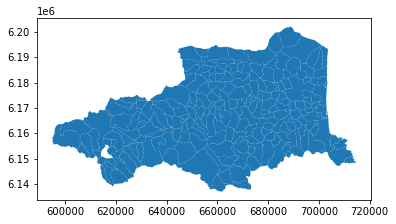

In [21]:
%matplotlib inline
ax=gdf_comm66.plot()

### Comment reprojeter un jeu de données

La conversion en **Lambert 93** se fait avec la méthode `to_crs` qui accepte en paramètre la définition du SCR de sortie ou, plus simplement, le code EPSG du SCR.

Exemple : Générons un nouveau `GeoDataFrame` en Lambert 93 à partir du jeu de données _Lignes du Réseau Ferré National_ en WGS84. On peut voir le SCR avec la propriété `crs`, mais aussi en affichant les données avec `plot`.


In [22]:
gdf_lignes_rfn = gpd.read_file(f_lignes_rfn)
gdf_lignes_rfn.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

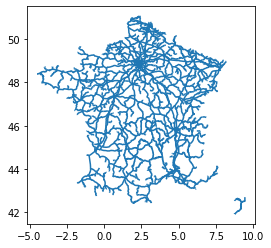

In [23]:
# ce sont les longitudes et latitudes en degrés décimaux qui s'affichent sur les 2 axes.
gdf_lignes_rfn.plot()

<AxesSubplot:>

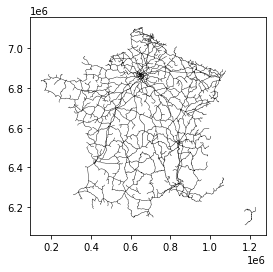

In [24]:
# conversion en Lambert 93
gdf_lignes_l93 = gdf_lignes_rfn.to_crs("EPSG:2154")
# ceci fonctionne aussi
gdf_lignes_l93 = gdf_lignes_rfn.to_crs(2154)
gdf_lignes_l93.plot(color='black', lw=0.4)

<AxesSubplot:>

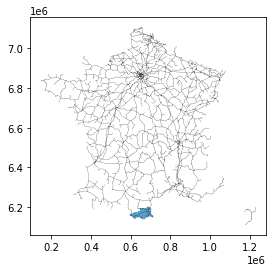

In [25]:
# que se passe t-il quand on essaie d'afficher 2 gdf dans 2 SCR différents ?
# ça ne fonctionne pas ! (remplacer gdf_lignes_l93 par gdf_lignes_rfn ci dessous)
# il faut que les 2 gdf partagent le même SCR
ax1=gdf_comm66.plot()
gdf_lignes_l93.plot(ax=ax1, color='black', lw=0.2)

### Comment calculer la longueur ou la surface d'une entité ?

Appliquées à une colonne géométrique (ou à un GeoDataFrame), les propriétés `length` et `area` renvoient respectivement **la longueur et la surface** des entités.

Attention, cela ne fonctionne que si le jeu de données est **dans un système de coordonnées métriques**. Dans ce cas, les valeurs sont **en mètres et en mètres carrés**.

In [26]:
# exemple : surface des communes en km2
# le résultat est un objet Series, indexé comme les données d'origine
surf_km2 = gdf_comm66.area / 1000000
perimetre_km = gdf_comm66.length / 1000
surf_km2

INSEE_COM
66020    17.944774
66084     9.589590
66130    17.091949
66149    11.011909
66111    16.007069
           ...    
66182    10.309600
66017    15.257890
66171    15.795376
66141    13.430540
66158    13.903733
Length: 226, dtype: float64

In [27]:
# longueur des 5 premieres voies ferrees : 
# ça fonctionne avec le lambert 93 (unité mètre)
print(gdf_lignes_l93.iloc[:5].length / 1000)
# mais pas avec le wgs84 (unité degré décimal), cf warning
print(gdf_lignes_rfn.iloc[:5].length)


0     1.135458
1     2.136654
2     1.051183
3    14.406385
4     0.517312
dtype: float64
0    0.013672
1    0.025946
2    0.011544
3    0.157381
4    0.005868
dtype: float64


C:\Users\BernardC\AppData\Local\Temp/ipykernel_3164/3319018578.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(gdf_lignes_rfn.iloc[:5].length)


### Comment ajouter ou mettre à jour une colonne ?

Pour ajouter une nouvelle colonne à un GeoDataFrame, le plus direct est d'utiliser cette syntaxe :

    gdf_dest['nouvelle_colonne'] = donnee
    
Ici, "donnee" peut être un scalaire, ou un objet Series, ou un tableau numpy de N éléments si le tableau a N lignes.


In [28]:
# exemple scalaire : 
# ajouter une nouvelle colonne "longueur_m" initialisée à 0 
print("liste des colonnes avant : ", gdf_lignes_l93.columns)
gdf_lignes_l93['longueur_m'] = 0 
print("liste des colonnes avant : ", gdf_lignes_l93.columns)
gdf_lignes_l93.head()


liste des colonnes avant :  Index(['code_ligne', 'rg_troncon', 'pk_debut_r', 'pk_fin_r', 'libelle',
       'mnemo', 'geometry'],
      dtype='object')
liste des colonnes avant :  Index(['code_ligne', 'rg_troncon', 'pk_debut_r', 'pk_fin_r', 'libelle',
       'mnemo', 'geometry', 'longueur_m'],
      dtype='object')


code_ligne  rg_troncon pk_debut_r pk_fin_r             libelle     mnemo  \
0     216308         1.0    000+000  001+412          ExploitÃ©e  EXPLOITE   
1     059910         1.0    000+000  002+104  DÃ©classÃ©e vendue     DEC V   
2     089306         1.0    000+000  000+974          ExploitÃ©e  EXPLOITE   
3     680000         1.0    480+827  495+180          ExploitÃ©e  EXPLOITE   
4     296000         1.0    020+760  021+373  DÃ©classÃ©e vendue     DEC V   

                                            geometry  longueur_m  
0  LINESTRING (663562.686 7075383.735, 663411.437...           0  
1  LINESTRING (956891.198 6788415.962, 956807.705...           0  
2  LINESTRING (888469.100 6857811.021, 888383.323...           0  
3  LINESTRING (697078.462 6166776.373, 697050.692...           0  
4  LINESTRING (700936.087 7074210.974, 700941.105...           0

In [29]:
# exemple Series : maj d'1 colonne existante
gdf_lignes_l93['longueur_m'] = gdf_lignes_l93.length  
gdf_lignes_l93.head()

code_ligne  rg_troncon pk_debut_r pk_fin_r             libelle     mnemo  \
0     216308         1.0    000+000  001+412          ExploitÃ©e  EXPLOITE   
1     059910         1.0    000+000  002+104  DÃ©classÃ©e vendue     DEC V   
2     089306         1.0    000+000  000+974          ExploitÃ©e  EXPLOITE   
3     680000         1.0    480+827  495+180          ExploitÃ©e  EXPLOITE   
4     296000         1.0    020+760  021+373  DÃ©classÃ©e vendue     DEC V   

                                            geometry    longueur_m  
0  LINESTRING (663562.686 7075383.735, 663411.437...   1135.458195  
1  LINESTRING (956891.198 6788415.962, 956807.705...   2136.654289  
2  LINESTRING (888469.100 6857811.021, 888383.323...   1051.183491  
3  LINESTRING (697078.462 6166776.373, 697050.692...  14406.385419  
4  LINESTRING (700936.087 7074210.974, 700941.105...    517.312004

In [30]:
# exemple tableau numpy 1D
gdf_comm66['new_id'] = np.arange(1, len(gdf_comm66) + 1)
gdf_comm66.head()

INSEE_DEP INSEE_ARR  POPULATION  SURFACE_HA CODE_POST  \
INSEE_COM                                                         
66020            66         3         813        1761     66210   
66084            66         1        1296         939     66300   
66130            66         3        1336        1713     66340   
66149            66         3        6063        1087     66500   
66111            66         3         149        1590     66130   

                           NOM  \
INSEE_COM                        
66020                 Bolquère   
66084                 Fourques   
66130                   Osséja   
66149                   Prades   
66111      Montalba-le-Château   

                                                    geometry  new_id  
INSEE_COM                                                             
66020      POLYGON ((618666.300 6161144.300, 618696.200 6...       1  
66084      POLYGON ((679225.100 6166035.500, 679232.800 6...       2  
66130      POLYGON ((620776.800 6145919.900, 620701.000 6...       3  
66149      POLYGON ((653388.000 6165444.000, 653376.200 6...       4  
66111      POLYGON ((661593.300 6177188.600, 661592.900 6...       5

Avec les Series, on peut ajouter une nouvelle colonne en faisant "matcher" les index de lignes ... même si la nouvelle colonne présente des valeurs manquantes.

In [31]:
new_series = pd.Series(np.array([9002, 9003], dtype=np.int32), index=['66084', '66130'])
gdf_comm66['new_id2'] = new_series
gdf_comm66.head()

INSEE_DEP INSEE_ARR  POPULATION  SURFACE_HA CODE_POST  \
INSEE_COM                                                         
66020            66         3         813        1761     66210   
66084            66         1        1296         939     66300   
66130            66         3        1336        1713     66340   
66149            66         3        6063        1087     66500   
66111            66         3         149        1590     66130   

                           NOM  \
INSEE_COM                        
66020                 Bolquère   
66084                 Fourques   
66130                   Osséja   
66149                   Prades   
66111      Montalba-le-Château   

                                                    geometry  new_id  new_id2  
INSEE_COM                                                                      
66020      POLYGON ((618666.300 6161144.300, 618696.200 6...       1      NaN  
66084      POLYGON ((679225.100 6166035.500, 679232.800 6...       2   9002.0  
66130      POLYGON ((620776.800 6145919.900, 620701.000 6...       3   9003.0  
66149      POLYGON ((653388.000 6165444.000, 653376.200 6...       4      NaN  
66111      POLYGON ((661593.300 6177188.600, 661592.900 6...       5      NaN

### Comment mettre à jour les valeurs d'une colonne avec un critère ?

TODO

### Comment supprimer une colonne ?

Avec `drop` : renvoie un nouveau DataFrame sans les colonnes passées en argument.

In [32]:
gdf_comm66 = gdf_comm66.drop(columns='new_id2')
gdf_comm66.head()

INSEE_DEP INSEE_ARR  POPULATION  SURFACE_HA CODE_POST  \
INSEE_COM                                                         
66020            66         3         813        1761     66210   
66084            66         1        1296         939     66300   
66130            66         3        1336        1713     66340   
66149            66         3        6063        1087     66500   
66111            66         3         149        1590     66130   

                           NOM  \
INSEE_COM                        
66020                 Bolquère   
66084                 Fourques   
66130                   Osséja   
66149                   Prades   
66111      Montalba-le-Château   

                                                    geometry  new_id  
INSEE_COM                                                             
66020      POLYGON ((618666.300 6161144.300, 618696.200 6...       1  
66084      POLYGON ((679225.100 6166035.500, 679232.800 6...       2  
66130      POLYGON ((620776.800 6145919.900, 620701.000 6...       3  
66149      POLYGON ((653388.000 6165444.000, 653376.200 6...       4  
66111      POLYGON ((661593.300 6177188.600, 661592.900 6...       5

### Comment supprimer une ligne ?

`drop` peut également servir à supprimer des lignes, il suffit d'appliquer la fonction à l'index des lignes.

Quand on essaie de supprimer une ligne qui n'existe pas, une exception est levée. Ce comportement par défaut peut être changé avec le paramètre `errors`.

In [33]:
gdf_test = gdf_comm66.drop(index='66084', errors='ignore')
gdf_test.head()

INSEE_DEP INSEE_ARR  POPULATION  SURFACE_HA CODE_POST  \
INSEE_COM                                                         
66020            66         3         813        1761     66210   
66130            66         3        1336        1713     66340   
66149            66         3        6063        1087     66500   
66111            66         3         149        1590     66130   
66165            66         3         624        1811     66320   

                           NOM  \
INSEE_COM                        
66020                 Bolquère   
66130                   Osséja   
66149                   Prades   
66111      Montalba-le-Château   
66165                    Rodès   

                                                    geometry  new_id  
INSEE_COM                                                             
66020      POLYGON ((618666.300 6161144.300, 618696.200 6...       1  
66130      POLYGON ((620776.800 6145919.900, 620701.000 6...       3  
66149      POLYGON ((653388.000 6165444.000, 653376.200 6...       4  
66111      POLYGON ((661593.300 6177188.600, 661592.900 6...       5  
66165      POLYGON ((660745.900 6177379.000, 660782.300 6...       6

### Comment faire une requête spatiale ?

Par requête spatiale nous entendons : sélectionner des entités d'après leur position.

Plusieurs possibilités s'offrent à nous dans **GeoPandas**.

- pour sélectionner des entités d'après leurs coordonnées géographiques, on peut utiliser `cx`
- il existe des fonctions de **prédicat géométrique** telles que `intersects`, `within`, etc. Elle peuvent servir à tester si une entité A intersecte une entité B. Elles s'appliquent bien à 1 entité en particulier, mais sont mal adaptée à un `GeoDataFrame` en entier.
- la fonction `sjoin` est destinée aux jointures spatiales et peu également répondre à des questions telles que : quelles sont les voies ferrées qui intersectent les communes du département ?


#### La méthode `cx`

`cx` renvoie un sous-ensemble selon les coordonnées géographiques. La syntaxe ressemble à l'indexation des tableaux, exemple : `gdf.cx[xmin:xmax, ymin:ymax]`.

<AxesSubplot:>

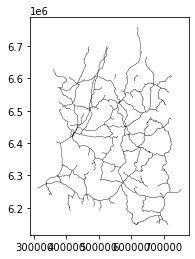

In [34]:
# exemple : les voies ferrées du quart sud-ouest de la France
# coordonnées Lambert 93 avec x < 700 000 et y < 6 600 000
gdf_lignes_SO = gdf_lignes_l93.cx[:700000, :6600000]
gdf_lignes_SO.plot(color='black', lw=0.4)

#### La méthode `intersects`

Cette méthode prend en paramètres 2 géométries, et renvoie 1 booléen (**Vrai** si les 2 géométries se recouvrent). On peut aussi passer en paramètres 1 ensemble A de géométries (sous forme d'itérable) et 1 géométrie B particulière : le retour sera un tableau de booléens.

TODO : comment retourner des géométries avec loc ?

In [35]:
# exemple : quelles lignes intersectent la commune de Font-Romeu-Odeillo-Via ?
gdf_fontromeu = gdf_communes[gdf_communes.NOM=='Font-Romeu-Odeillo-Via']
print(gdf_fontromeu.index)

geom_fontromeu = gdf_fontromeu.iloc[0, -1]
print(type(geom_fontromeu))

subset_spatial = gdf_lignes_l93.intersects(geom_fontromeu)
print(gdf_lignes_l93[subset_spatial])


Index(['66124'], dtype='object', name='INSEE_COM')
<class 'shapely.geometry.polygon.Polygon'>
     code_ligne  rg_troncon pk_debut_r pk_fin_r     libelle     mnemo  \
1548     669000         1.0    000-218  062+561  ExploitÃ©e  EXPLOITE   

                                               geometry    longueur_m  
1548  LINESTRING (648267.713 6166165.937, 648221.616...  62624.816187  


<AxesSubplot:>

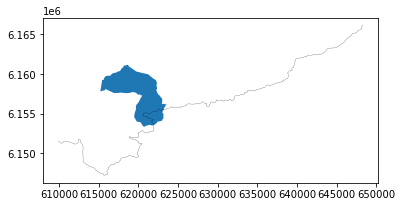

In [36]:
ax1=gdf_fontromeu.plot()
gdf_lignes_l93[subset_spatial].plot(ax=ax1, color='black', lw=0.2)

#### Jointure spatiale

Voir <https://geopandas.org/en/stable/docs/user_guide/mergingdata.html>

Nous cherchons les lignes qui intersectent les communes du département. Une jointure spatiale peut nous permettre de répondre à cette question dans GeoPandas, mais attention, ce n'est si simple : il peut y avoir N lignes pour 1 commune, mais aussi 1 lignes pour N communes !

Voir le paragraphe suivent pour le détail des explications.

### Comment fonctionnent les jointures spatiales dans GeoPandas ?

La syntaxe de la jointure spatiale est la suivante : 

    gdf_A.sjoin(gdf_B, how, predicate)
    
    
Le paramètre `predicate` est la relation géométrique, exemple : `intersects`, `touches`, `within`, etc.

Le paramètre `how` est tout particulièrement important :

* avec `how='inner'` on obtient la **géometrie de gauche**, les **indices des 2**, et **seules les lignes en relation** sont conservées.
* avec `how='left'` on obtient la **géometrie de gauche**, les **indices de gauche** et **toutes les lignes de gauche** sont conservées.

In [37]:
# sjoin inner
gdf_subset = gdf_lignes_l93.sjoin(gdf_comm66, how='inner', predicate='intersects')
# les voies ferrees qui intersectent plusieurs communes sont dupliquees !
print(len(gdf_subset), "/", len(gdf_lignes_l93))
print(gdf_subset.index)
print(gdf_subset.columns)

97 / 1833
Int64Index([   3,  300,  798,    3,  300,    3,  300,    3,    3,    3, 1151,
             138,  138,  138, 1151,  138,  138,  138,  138,  138,  334,  138,
             280,  280, 1548,  280,  280,  300,  300,  300,  300,  300,  300,
             300,  300,  941,  977,  371,  421,  798,  727,  940, 1151,  798,
             941,  977,  977,  977,  977, 1151,  977, 1548,  977,  977,  977,
             977,  977,  977,  977,  977,  977,  977,  977,  977, 1548,  977,
            1151, 1151, 1151, 1151, 1151, 1151, 1151, 1151, 1151, 1151, 1151,
            1548, 1548, 1548, 1548, 1548, 1548, 1548, 1548, 1548, 1548, 1548,
            1548, 1548, 1548, 1548, 1548, 1548, 1548, 1548, 1548],
           dtype='int64')
Index(['code_ligne', 'rg_troncon', 'pk_debut_r', 'pk_fin_r', 'libelle',
       'mnemo', 'geometry', 'longueur_m', 'index_right', 'INSEE_DEP',
       'INSEE_ARR', 'POPULATION', 'SURFACE_HA', 'CODE_POST', 'NOM', 'new_id'],
      dtype='object')


In [38]:
# exemple : la ligne avec l'index 3 est dupliquée 6 fois (car 6 communes)
gdf_subset.loc[3, ('code_ligne', 'index_right', 'NOM',)]

code_ligne index_right                  NOM
3     680000       66024            Le Boulou
3     680000       66214            Tresserre
3     680000       66015  Banyuls-dels-Aspres
3     680000       66026             Brouilla
3     680000       66129              Ortaffa
3     680000       66065                 Elne

In [39]:
# sjoin left
gdf_subset = gdf_lignes_l93.sjoin(gdf_comm66, how='left', predicate='intersects')
print(len(gdf_subset), "/", len(gdf_lignes_l93))
print(gdf_subset.index)
print(gdf_subset.columns)

1916 / 1833
Int64Index([   0,    1,    2,    3,    3,    3,    3,    3,    3,    4,
            ...
            1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832],
           dtype='int64', length=1916)
Index(['code_ligne', 'rg_troncon', 'pk_debut_r', 'pk_fin_r', 'libelle',
       'mnemo', 'geometry', 'longueur_m', 'index_right', 'INSEE_DEP',
       'INSEE_ARR', 'POPULATION', 'SURFACE_HA', 'CODE_POST', 'NOM', 'new_id'],
      dtype='object')


In [40]:
# exemple avec les 10 premieres lignes du resultats
# les lignes 0, 1, 2 n'intersectent aucune commune (NaN)
# la ligne 3 intersecte 6 communes
gdf_subset.iloc[:10, -1]

0      NaN
1      NaN
2      NaN
3    109.0
3    135.0
3    146.0
3    163.0
3    120.0
3     40.0
4      NaN
Name: new_id, dtype: float64

**Conclusion** : pour trouver les voies ferrées qui intersectent les communes du département ET sans doublons, il faut :

1. faire une jointure spatiale de type `inner`
2. prendre l'index des lignes intersectées, supprimer les doublons
3. filtrer les voies ferrées avec le précédent index des lignes

nb de lignes : 97
nb de lignes (sans doublons) : 14


<AxesSubplot:>

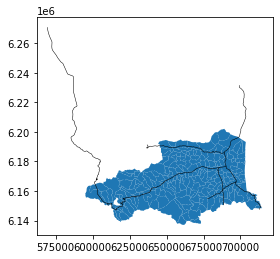

In [41]:
# conclusion : sjoin inner
gdf_sjoin = gdf_lignes_l93.sjoin(gdf_comm66, how='inner', predicate='intersects')
print("nb de lignes :", len(gdf_sjoin))
# recuperer l'index sans doublons
idx_subset = gdf_sjoin.index.drop_duplicates()
# nb de lignes ? 14
gdf_subset = gdf_lignes_l93.loc[idx_subset, ('code_ligne', 'mnemo', 'geometry')]
print("nb de lignes (sans doublons) :", len(gdf_subset))
ax1=gdf_comm66.plot()
gdf_subset.plot(ax=ax1, color='black', lw=0.5)

### Comment combiner les géométries de 2 couches ?

La méthode `overlay` de **geopandas** étend les fonctionnalités de celle du même nom dans le package **shapely**. Dans geopandas, elle s'applique à 2 `GeoDataFrame` : dans les données en sortie, les géométries sont découpées et les attributs de départ sont conservés.

La syntaxe est la suivante :

    gdf_A.overlay(gdf_B, how = 'operation geom')

Les opérations suivantes sont disponibles pour les géométries :

- _union_ (conserver tout, même les parties non communes)
- _intersection_ (conserver les parties communes uniquement)
- _symmetric_difference_
- _difference_ (conserver les parties non-communes uniquement)
- _identity_ (conserve les géométries de la couche A, autrement dit couche A découpée en fonction de la couche B)

D'autre part, si les types géométriques sont différents (exemple : ligne et polygone), c'est le type géométrique du GeoDataFrame A qui sera conservé.

Exemple : nous cherchons la longueur totale de voie ferrée sur chaque ligne. Pour la calculer, il faut commencer par intersecter les géométries des voies ferrées et des communes.


In [51]:
# intersection voie ferrée X communes
gdf_inter = gdf_lignes_l93.overlay(gdf_comm66, how='intersection')
# calculer longueur des trancons intersectes
gdf_inter['longueur_m'] = gdf_inter.length
gdf_inter.head()

code_ligne  rg_troncon pk_debut_r pk_fin_r                          libelle  \
0     680000         1.0    480+827  495+180                       ExploitÃ©e   
1     677000         1.0    404+674  510+536                       ExploitÃ©e   
2     680000         1.0    480+827  495+180                       ExploitÃ©e   
3     837000         1.0    000+000  024+587                       ExploitÃ©e   
4     680000         1.0    495+180  501+214  TransfÃ©rÃ©e en voie de service   

      mnemo   longueur_m INSEE_DEP INSEE_ARR  POPULATION  SURFACE_HA  \
0  EXPLOITE  3143.405587        66         1        9103        2129   
1  EXPLOITE  3731.701684        66         1        9103        2129   
2  EXPLOITE  1177.874441        66         1        5396        1442   
3  EXPLOITE  1106.996249        66         1        5396        1442   
4        VS  2371.091316        66         1        5396        1442   

  CODE_POST        NOM  new_id  \
0     66200       Elne      40   
1     66200       Elne      40   
2     66160  Le Boulou     109   
3     66160  Le Boulou     109   
4     66160  Le Boulou     109   

                                            geometry  
0  LINESTRING (697078.462 6166776.373, 697050.692...  
1  LINESTRING (696479.138 6168335.587, 696565.697...  
2  LINESTRING (687292.353 6160000.142, 687053.479...  
3  LINESTRING (688422.235 6157413.852, 688497.981...  
4  LINESTRING (686552.666 6159103.349, 686442.731...

**Remarque** :

- l'index de ligne du GeoDataFrame B (ici, le code Insee des communes du 66) disparaît du résultat !
- comme on a choisi _intersection_, les tronçons en dehors des polygones sont éliminés

<AxesSubplot:>

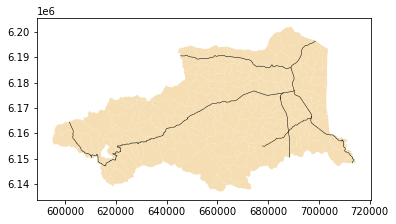

In [49]:
ax1=gdf_comm66.plot(color='wheat')
gdf_inter.plot(ax=ax1, color='black', lw=0.5)

In [52]:
# calculer nb troncon et longueur totale par communes
calcul_long_m = gdf_inter.groupby('NOM').agg(
    nb_troncons=("code_ligne", "size"),
    total_long_m=("longueur_m", "sum")
)
calcul_long_m.head()

nb_troncons  total_long_m
NOM                                           
Argelès-sur-Mer                1   6477.972069
Banyuls-dels-Aspres            2   6364.639539
Banyuls-sur-Mer                1   5141.061906
Bolquère                       1   2042.209993
Bouleternère                   1   3413.277277

### Comment importer des données CSV géoréférencées avec 2 colonnes longitude, latitude ?

Dans le code suivant, nous allons :

- ouvrir les fichiers SNCF "référentiel" et "fréquentation" des gares
- faire une jointure entre les 2 tables


In [55]:
# appel avec spécification des colonnes
df_gares = pd.read_csv(
    f_liste_gares, 
    sep=';',
    usecols=[
        'CODE_UIC', 'LIBELLE',
        'COMMUNE', 'DEPARTEMEN', 
        'X_L93', 'Y_L93'
    ],
    dtype={
        'CODE_UIC': str, 'LIBELLE': str,
        'COMMUNE': str, 'DEPARTEMEN': str, 
        'X_L93': float, 'Y_L93': float,
        'X_WGS84': float, 'Y_WGS84': float
    }
)


In [56]:
df_frequentation = pd.read_csv(
    f_frequentation_gares, 
    sep=';',
    usecols=[
        'Nom de la gare', 'Code UIC complet', 
        'Total Voyageurs 2020', 'Total Voyageurs 2019',
        'Total Voyageurs 2018', 'Total Voyageurs 2017',
        'Total Voyageurs 2016', 'Total Voyageurs 2015'
    ],
    dtype={
        'Nom de la gare': str, 'Code UIC complet': str, 
        'Total Voyageurs 2020': int, 'Total Voyageurs 2019': int,
        'Total Voyageurs 2018': int, 'Total Voyageurs 2017': int,
        'Total Voyageurs 2016': int, 'Total Voyageurs 2015': int
    }
)


In [60]:
# joindre les statistiques fréquentation au référentiel gare
# ici, la jointure interne se fera sur la colonne nommée 'CODE_UIC' à gauche, 'Code UIC complet' à droite
df_gares_new = pd.merge(df_gares, df_frequentation, left_on='CODE_UIC', right_on='Code UIC complet')
print("Nb enregistrement gares : ", len(df_gares))
print("Nb enregistrement frequentation : ", len(df_frequentation))
print("Nb enregistrement après jointure : ", len(df_gares_new))

Nb enregistrement gares :  4144
Nb enregistrement frequentation :  2967
Nb enregistrement après jointure :  3563


In [66]:
# filtrer les données (uniquement les gares des P.O.)
df_gares_66 = df_gares_new.query("DEPARTEMEN=='PYRENEES-ORIENTALES'")
print("Nb enregistrement filtré : ", len(df_gares_66))

Nb enregistrement filtré :  46


Nous pouvons maintenant créer un nouveau `GeoDataFrame` avec la méthode `points_from_xy` de geopandas. Nous prenons soin de spécifier le CRS du jeu de données (ici, **EPSG:4326**).

Cf. <https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html>



In [67]:
gdf_gares_l93 = gpd.GeoDataFrame(
    df_gares_66, 
    geometry=gpd.points_from_xy(
        df_gares_66.X_L93, df_gares_66.Y_L93, crs="EPSG:2154"))
gdf_gares_l93.head()

CODE_UIC                           LIBELLE                   COMMUNE  \
4    87784512                          Le Soler                  LE SOLER   
11   87784736                             Nyers                      NYER   
300  87784686     Villefranche-Vernet-les-Bains  VILLEFRANCHE-DE-CONFLENT   
301  87784686     Villefranche-Vernet-les-Bains  VILLEFRANCHE-DE-CONFLENT   
616  87784769  Fontpédrouse-St-Thomas-les-Bains              FONTPÉDROUSE   

              DEPARTEMEN        X_L93         Y_L93  \
4    PYRENEES-ORIENTALES  682569.1484  6.175407e+06   
11   PYRENEES-ORIENTALES  639377.8490  6.160491e+06   
300  PYRENEES-ORIENTALES  648223.8313  6.165955e+06   
301  PYRENEES-ORIENTALES  648202.9095  6.165970e+06   
616  PYRENEES-ORIENTALES  633225.5654  6.157442e+06   

                      Nom de la gare Code UIC complet  Total Voyageurs 2020  \
4                           Le Soler         87784512                  1320   
11                              Nyer         87784736                    32   
300  Villefranche - Vernet-les-Bains         87784686                145043   
301  Villefranche - Vernet-les-Bains         87784686                145043   
616                     Fontpédrouse         87784769                  2240   

     Total Voyageurs 2019  Total Voyageurs 2018  Total Voyageurs 2017  \
4                      17                   767                  2317   
11                    113                    96                   177   
300                138231                133167                149035   
301                138231                133167                149035   
616                  3012                  2886                  3009   

     Total Voyageurs 2016  Total Voyageurs 2015  \
4                    2229                  3056   
11                    236                   119   
300                147923                149814   
301                147923                149814   
616                  3703                  3614   

                           geometry  
4    POINT (682569.148 6175407.081)  
11   POINT (639377.849 6160490.633)  
300  POINT (648223.831 6165955.311)  
301  POINT (648202.910 6165970.141)  
616  POINT (633225.565 6157442.038)

Dans la foulée, essayons de visualiser la fréquentation des gares sur une nouvelle figure. 

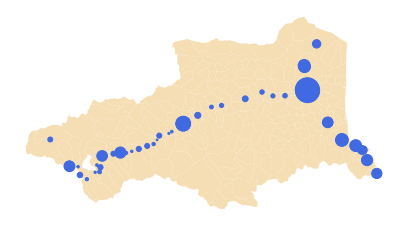

In [68]:
# calcul taille symbole = sqrt(freq 2020 / pi)  
# (surface du symbole proportionnel au nb voyageur) 
#s_freq_2020 = gdf_gares_l93["Total Voyageurs 2020"] / 1000
s_freq_2020 = np.sqrt(gdf_gares_l93["Total Voyageurs 2020"]/np.pi)
# créer la figure
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,14))
gdf_comm66.plot(ax=ax, color="wheat")
gdf_gares_l93.plot(ax=ax, marker='o', color='royalblue', markersize=s_freq_2020)
ax.set_axis_off()